### creating training annotations

In [ ]:
import json
with open("trainval/annotations/bbox-annotations.json") as json_data:
    data = json.load(json_data)

In [ ]:
data.keys()

dict_keys(['images', 'annotations', 'categories', 'licenses'])

In [ ]:
data_annot = pd.DataFrame(data['annotations'])

In [ ]:
data_images = pd.DataFrame(data['images'])

In [ ]:
data_categories = pd.DataFrame(data['categories'])
data_categories

,id,name,supercategory
0,1,person,none
1,2,car,none


In [ ]:
data_annot.drop(["license","segmentation","iscrowd"], axis=1, inplace=True)

In [ ]:
# data_annot[data_annot['segmentation'].apply(len)>0]

In [ ]:
data_images.rename({"id": "image_id"}, axis=1, inplace=True)

In [ ]:
data_images.drop("license", axis=1, inplace=True)

In [ ]:
merged_df = data_images.merge(data_annot, on="image_id")

In [ ]:
# Convert Coco bb to Yolo
def coco_to_yolo(x1, y1, w, h, image_w, image_h):
    return [((2*x1 + w)/(2*image_w)) , ((2*y1 + h)/(2*image_h)), w/image_w, h/image_h]

In [ ]:
coco_to_yolo(153, 124, 658, 643,1024,768)

[0.470703125, 0.580078125, 0.642578125, 0.8372395833333334]

In [ ]:
merged_df["yolo_labels"] = merged_df.apply(lambda x: coco_to_yolo(x["bbox"][0], x["bbox"][1], x["bbox"][2], x["bbox"][3], x["width"], x["height"]), axis=1)

In [ ]:
merged_df_req = merged_df[["file_name","category_id", "yolo_labels"]]

In [ ]:
merged_df_req['category_id'] = merged_df_req['category_id'].apply(lambda x: x-1)

In [ ]:
merged_df_req_grouped = merged_df_req.groupby('file_name').agg({"category_id": list, "yolo_labels": list}).reset_index()

In [ ]:
from tqdm import tqdm

In [ ]:
merged_df_req_grouped['tuple'] = merged_df_req_grouped.apply(lambda x: tuple(zip(x.category_id,x.yolo_labels)), axis=1)

In [ ]:
len(merged_df_req_grouped['tuple'].iloc[0])

4

In [ ]:
def merged_str(x):
    return " ".join([str(i) for i in [x[0]]+list(x[1])])

# merged_str(merged_df_req_grouped['tuple'].iloc[0][0])

In [ ]:
for i in tqdm(merged_df_req_grouped.itertuples()):
    # print(i.file_name,len(i.tuple))
    filename = i.file_name.split(".")[0]
    # print(filename)
    len_tuple = len(i.tuple)
    with open(f"annot_2/{filename}.txt", "w") as f:
        for j in range(len_tuple):
            curr_tupel = i.tuple[j]
            str_curr_tuple = merged_str(curr_tupel)
            # for k in curr_tupel:
            #     f.write(f"{k}")
            f.write(str_curr_tuple)
            f.write("\n")
        # break
        

2239it [00:03, 590.15it/s]


In [ ]:
import glob
images_list = glob.glob("yolov5/data/CARPERSON/obj/train")
print(images_list)

# Create train.txt file
file = open("yolov5/data/CARPERSON/test.txt", "w") 
file.write("\n".join(images_list)) 
file.close() 

['yolov5/data/CARPERSON/obj/train']


In [ ]:
merged_df.head(2)

,file_name,width,height,image_id,category_id,bbox,area,id,yolo_labels
0,image_000000001.jpg,1024,768,0,1,"[846, 145, 146, 477]",0.088554,0,"[0.8974609375, 0.4993489583333333, 0.142578125..."
1,image_000000001.jpg,1024,768,0,1,"[848, 216, 175, 551]",0.122611,1,"[0.91357421875, 0.6399739583333334, 0.17089843..."


## train

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip install pandas
import os
os.chdir("/content/drive/MyDrive/EagleView/yolov5")

In [ ]:
!pip install -r requirements.txt

In [4]:
import torch
import os
import pandas as pd
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla T4)


In [5]:
torch.cuda.is_available()

True

In [ ]:
!python train.py --data coco.yaml --weights yolov5s.pt --img 416 --batch 16 --epochs 150 --cache

In [ ]:
!python detect.py --weights runs/train/exp9/weights/best.pt --img 416 --conf 0.1 --source /content/drive/MyDrive/EagleView/yolov5/data/CARPERSON/obj/train/image_000000023.jpg

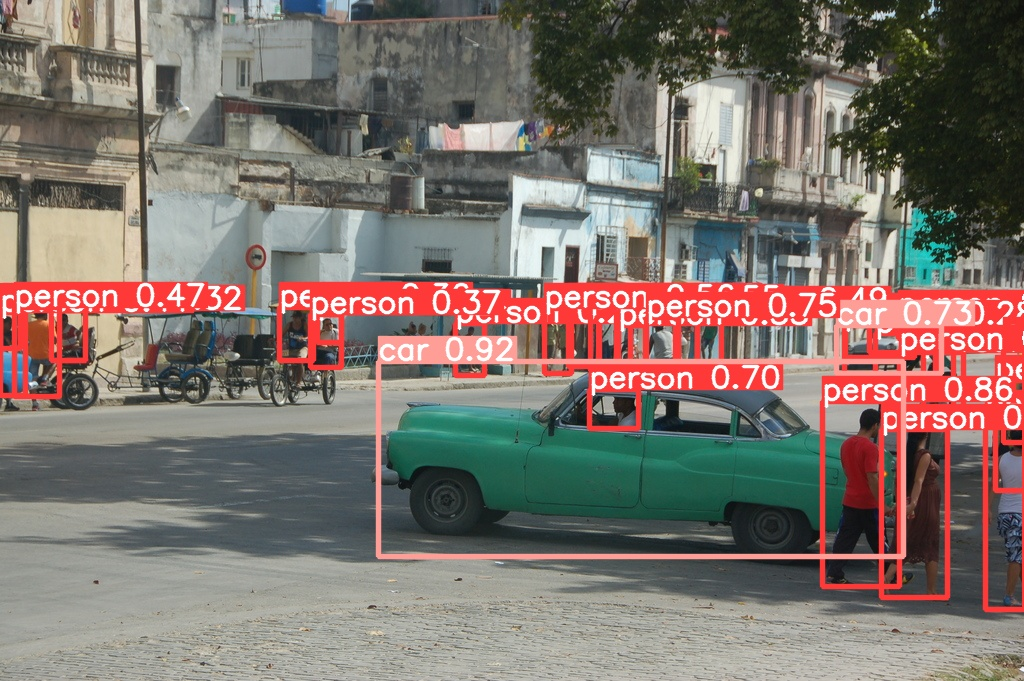

In [23]:

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/drive/MyDrive/EagleView/yolov5/runs/detect/exp5/*.jpg'): 
    display(Image(filename=imageName))
    print("\n")